### install libraries

In [ ]:
!pip install fuzzywuzzy

In [ ]:
!pip install python-levenshtein

### imports

In [1]:
import numpy as np
import pandas as pd
import itertools
from fuzzywuzzy import fuzz
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

### load train data

In [2]:
train = pd.read_csv('../data-quora-question-pairs/quora_train.csv')
train.dropna(how='any', inplace=True)

In [3]:
train.head()

,question1,question2,is_duplicate,tokenSortRatio,tokenSetRatio,wratio
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,93,100,95
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,63,86,86
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,63,63,60
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,24,28,27
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,47,67,86


### create levenshtein string distance feature

In [4]:
from Levenshtein import distance

In [5]:
def get_dist(row):
    return distance(row['question1'].lower(), row['question2'].lower())

In [6]:
train['distance'] = train.apply(get_dist, axis = 1)

### explore parts of speech features

In [11]:
import spacy

In [14]:
nlp = spacy.load('en')

In [15]:
doc = nlp(u'Apple is looking at buying the best India startup for $1 billion')

for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
            token.shape_, token.is_alpha, token.is_stop)

Apple Apple PROPN NNP nsubj Xxxxx True False
is be VERB VBZ aux xx True True
looking look VERB VBG ROOT xxxx True False
at at ADP IN prep xx True True
buying buy VERB VBG pcomp xxxx True False
the the DET DT det xxx True True
best good ADJ JJS amod xxxx True False
India India PROPN NNP compound Xxxxx True False
startup startup NOUN NN dobj xxxx True False
for for ADP IN prep xxx True True
$ $ SYM $ quantmod $ False False
1 1 NUM CD compound d False False
billion billion NUM CD pobj xxxx True False


In [16]:
doc = nlp(train.question2[15])
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

Trump 11 16 ORG
US 61 63 GPE
US 88 90 GPE


In [17]:
train.question1[15]

'What would a Trump presidency mean for current international master’s students on an F1 visa?'

In [18]:
train.question2[15]

'How will a Trump presidency affect the students presently in US or planning to study in US?'

In [19]:
doc = nlp(train.question2[12])

for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_)

How how ADV WRB
can can VERB MD
you -PRON- PRON PRP
make make VERB VB
physics physics NOUN NN
easy easy ADJ JJ
to to PART TO
learn learn VERB VB
? ? PUNCT .


In [20]:
doc = nlp(train.question1[12])

for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_)

What what PRON WP
can can VERB MD
make make VERB VB
Physics Physics PROPN NNP
easy easy ADJ JJ
to to PART TO
learn learn VERB VB
? ? PUNCT .


In [21]:
doc = nlp(u'How can make physics you easy learn to ?')

for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_)

How how ADV WRB
can can VERB MD
make make VERB VB
physics physics NOUN NN
you -PRON- PRON PRP
easy easy ADV RB
learn learn VERB VBP
to to PART TO
? ? PUNCT .


### create parts of speech features

In [ ]:
def processQ(question1, question2):
    
    q1 = nlp(question1)
    q2 = nlp(question2)
    
    v1, v2 = set(), set()
    nn1, nn2 = set(), set()
    adj1, adj2 = set(), set()
    
    ne1 = set([x.text for x in q1.ents])
    ne2 = set([x.text for x in q2.ents])
    
    for token in q1:
        if token.pos_ == "VERB":
            v1.add(token.lemma_)
        elif token.pos_ == "ADV" or token.pos_ == "ADJ":
            adj1.add(token.lemma_)
        elif token.pos_ == "NOUN" or token.pos_ == "PROPN":
            nn1.add(token.lemma_)
            
    for token in q2:
        if token.pos_ == "VERB":
            v2.add(token.lemma_)
        elif token.pos_ == "ADV" or token.pos_ == "ADJ":
            adj2.add(token.lemma_)
        elif token.pos_ == "NOUN" or token.pos_ == "PROPN":
            nn2.add(token.lemma_)
            
    verb_diff =len(v1.union(v2) - v1.intersection(v2))/max(1, v1.union(v2))
    adj_diff = len(adj1.union(adj2) - adj1.intersection(adj2))/max(1, adj1.union(adj2))
    nn_diff = len(nn1.union(nn2) - nn1.intersection(nn2))/max(1, nn1.union(nn2))
    ne_diff = len(ne1.union(ne2) - ne1.intersection(ne2))/max(1, ne1.union(ne2))
    
    return verb_diff, adj_diff, nn_diff, ne_diff

In [ ]:
processQ(train.question1[1], train.question2[1])

(1.0, 1.0, 0.23076923076923078, 1.0)

In [ ]:
train.head()

,question1,question2,is_duplicate,tokenSortRatio,tokenSetRatio,wratio
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,93,100,95
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,63,86,86
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,63,63,60
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,24,28,27
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,47,67,86


In [ ]:
train['verb_diff'] = ''
train['adj_diff'] = ''
train['nn_diff'] = ''
train['ne_diff'] = ''

In [ ]:
train.head()

,question1,question2,is_duplicate,tokenSortRatio,tokenSetRatio,wratio,verb_diff,adj_diff,nn_diff,ne_diff
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,93,100,95,,,,
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,63,86,86,,,,
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,63,63,60,,,,
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,24,28,27,,,,
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,47,67,86,,,,


In [ ]:
import timeit

In [ ]:
from multiprocessing import  Pool
from functools import partial
import numpy as np
import numpy as np
import pandas as pd
import itertools
import spacy
import time
#from fuzzywuzzy import fuzz
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit

nlp = spacy.load('en_core_web_sm')

def parallelize(data, func, num_of_processes=4):
    data_split = np.array_split(data, num_of_processes)
    pool = Pool(num_of_processes)
    data = pd.concat(pool.map(func, data_split))
    pool.close()
    pool.join()
    return data

def run_on_subset(func, data_subset):
    return data_subset.apply(func, axis=1)

def parallelize_on_rows(data, func, num_of_processes=4):
    return parallelize(data, partial(run_on_subset, func), num_of_processes)


def processQ(question1, question2):
    
    q1 = nlp(question1)
    q2 = nlp(question2)
    
    v1, v2 = set(), set()
    nn1, nn2 = set(), set()
    adj1, adj2 = set(), set()
    
    ne1 = set([x.text for x in q1.ents])
    ne2 = set([x.text for x in q2.ents])
    
    for token in q1:
        if token.pos_ == "VERB":
            v1.add(token.lemma_)
        elif token.pos_ == "ADV" or token.pos_ == "ADJ":
            adj1.add(token.lemma_)
        elif token.pos_ == "NOUN" or token.pos_ == "PROPN":
            nn1.add(token.lemma_)
            
    for token in q2:
        if token.pos_ == "VERB":
            v2.add(token.lemma_)
        elif token.pos_ == "ADV" or token.pos_ == "ADJ":
            adj2.add(token.lemma_)
        elif token.pos_ == "NOUN" or token.pos_ == "PROPN":
            nn2.add(token.lemma_)
            
    verb_diff =len(v1.union(v2) - v1.intersection(v2))/max(1, len(v1)+len(v2))
    adj_diff = len(adj1.union(adj2) - adj1.intersection(adj2))/max(1, len(adj1)+len(adj2))
    nn_diff = len(nn1.union(nn2) - nn1.intersection(nn2))/max(1, len(nn1)+len(nn2))
    ne_diff = len(ne1.union(ne2) - ne1.intersection(ne2))/max(1, len(ne1)+len(ne2))
    
    return verb_diff, adj_diff, nn_diff, ne_diff

def nlpFeatures(row):
    row['verb_diff'], row['adj_diff'], row['nn_diff'], row['ne_diff'] = processQ(row['question1'], row['question2'])
    return row



In [ ]:
train = pd.read_csv('drive/My Drive/Colab Notebooks/quora_train.csv')
train.dropna(how='any', inplace=True)
train['verb_diff'] = ''
train['adj_diff'] = ''
train['nn_diff'] = ''
train['ne_diff'] = ''
start = time.time()
print("start.....")
fdata = parallelize_on_rows(train, nlpFeatures)
end = time.time()
print(end - start)
fdata.to_csv('drive/My Drive/Colab Notebooks/finaldata.csv', index=False)

start.....
12903.15952038765


In [ ]:
data = pd.read_csv('drive/My Drive/Colab Notebooks/finaldata.csv')

In [ ]:
data.shape

(404287, 10)

In [ ]:
data.head(5)

,question1,question2,is_duplicate,tokenSortRatio,tokenSetRatio,wratio,verb_diff,adj_diff,nn_diff,ne_diff
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,93,100,95,0.000000,0.000000,0.090909,1.0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,63,86,86,1.000000,1.000000,0.230769,1.0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,63,63,60,0.500000,0.333333,0.666667,1.0
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,24,28,27,0.666667,1.000000,1.000000,1.0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,47,67,86,1.000000,0.333333,0.600000,0.0


In [ ]:
data.columns

Index(['question1', 'question2', 'is_duplicate', 'tokenSortRatio',
       'tokenSetRatio', 'wratio', 'verb_diff', 'adj_diff', 'nn_diff',
       'ne_diff'],
      dtype='object')

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()

X = scaler.fit_transform(data[['tokenSortRatio', 'tokenSetRatio', 'wratio', 'verb_diff', 'adj_diff', 'nn_diff', 'ne_diff']])
y = data['is_duplicate'].values

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(270872, 7) (133415, 7) (270872,) (133415,)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=500, max_depth=10, random_state=0)

In [ ]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

y_pred = clf.predict(X_test)

In [ ]:
confusion_matrix(y_test, y_pred)

array([[65692, 18466],
       [18643, 30614]])

In [ ]:
accuracy_score(y_test, y_pred)

0.7218528651201139

In [ ]:
precision_score(y_test, y_pred, 'weighted')

0.623757131214344

In [ ]:
recall_score(y_test, y_pred, 'weighted')

0.6215157236534908

In [ ]:
f1_score(y_test, y_pred)

0.6237084045236352

In [ ]:
from sklearn.metrics import log_loss
log_loss(y_test, y_pred)

9.578753849279263

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import coo_matrix, hstack

In [ ]:
tfidf = TfidfVectorizer(analyzer = 'word',
                        stop_words = 'english',
                        lowercase = False,
                        max_features = 4000,
                        norm = 'l1')

BagOfWords = pd.concat([data.question1, data.question2], axis = 0)

tfidf.fit(BagOfWords)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=4000, min_df=1,
        ngram_range=(1, 1), norm='l1', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [ ]:
train_q1_tfidf = tfidf.transform(data.question1)
train_q2_tfidf = tfidf.transform(data.question2)

In [ ]:
#X = abs(train_q1_tfidf - train_q2_tfidf)
X = hstack([coo_matrix(train_q1_tfidf), coo_matrix(train_q2_tfidf), extra])
y = data['is_duplicate']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33)

In [ ]:
X.shape

(404287, 8007)

In [ ]:
clf = RandomForestClassifier(n_estimators=1000, max_depth=20, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
confusion_matrix(y_test, y_pred)

In [ ]:
train_q1_tfidf[0]+train_q2_tfidf[0]

<1x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 5 stored elements in Compressed Sparse Row format>

In [ ]:
tr = hstack([train_q1_tfidf, train_q2_tfidf, extra]).toarray().shape

In [ ]:
tr.shape

In [ ]:
tr = hstack([coo_matrix(train_q1_tfidf), coo_matrix(train_q2_tfidf)])

In [ ]:
extra = coo_matrix(data[['tokenSortRatio','tokenSetRatio', 'wratio', 'verb_diff', 'adj_diff', 'nn_diff','ne_diff']])

In [ ]:
extra.shape

(404287, 7)

### A1 model

In [ ]:
train.columns

Index(['question1', 'question2', 'is_duplicate', 'tokenSortRatio',
       'tokenSetRatio', 'wratio', 'distance'],
      dtype='object')

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()

X = scaler.fit_transform(train[['tokenSortRatio', 'tokenSetRatio', 'wratio', 'distance']])
y = train['is_duplicate'].values

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(270872, 4) (133415, 4) (270872,) (133415,)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=500, max_depth=10, random_state=0)

In [ ]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

y_pred = clf.predict(X_test)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
        
    A =(((C.T)/(C.sum(axis=1))).T)
    
    
    B =(C/C.sum(axis=0))
    
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [ ]:
(accuracy_score(y_test, y_pred), precision_score(y_test, y_pred, 'weighted'),
 recall_score(y_test, y_pred, 'weighted'))

(0.6955814563579807, 0.5752730313006218, 0.6705036847554662)

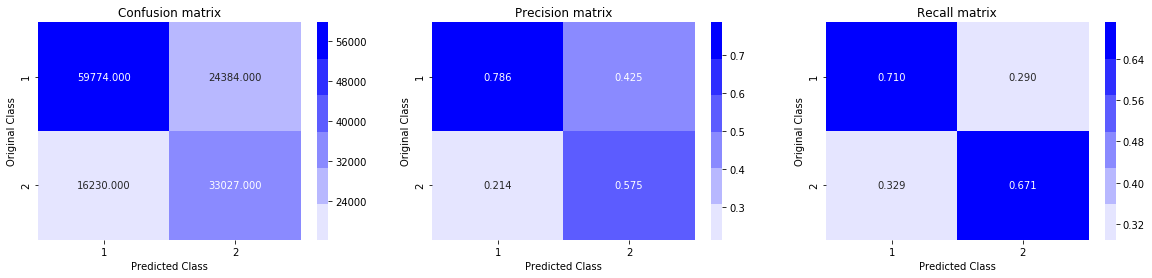

In [ ]:
plot_confusion_matrix(y_test, y_pred)

### A2 model

In [ ]:
train = pd.read_csv('drive/My Drive/Colab Notebooks/finaldata.csv')

In [ ]:
train['distance'] = train.apply(get_dist, axis = 1)

In [ ]:
scaler = StandardScaler()

X = scaler.fit_transform(train[['tokenSortRatio', 'tokenSetRatio', 'wratio', 'verb_diff', 'adj_diff', 'nn_diff', 'ne_diff', 'distance']])
y = data['is_duplicate'].values

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
clf = RandomForestClassifier(n_estimators=500, max_depth=10, random_state=0)

(270872, 8) (133415, 8) (270872,) (133415,)


In [ ]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
print(accuracy_score(y_test, y_pred), precision_score(y_test, y_pred, 'weighted'),
 recall_score(y_test, y_pred, 'weighted'))


0.725855413559195 0.6267135606090883 0.636701382544613


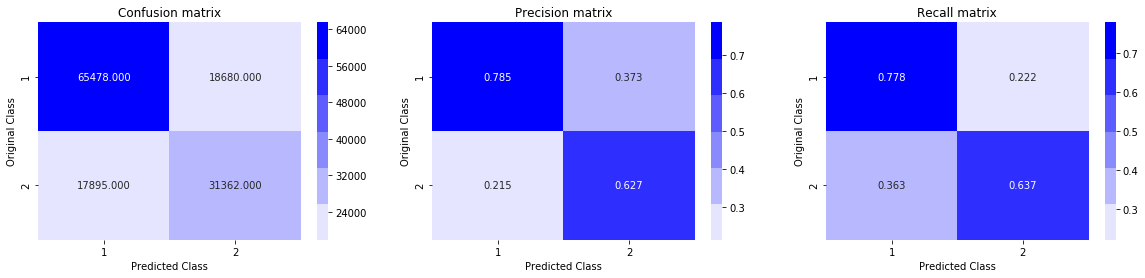

In [ ]:
plot_confusion_matrix(y_test, y_pred)